# ワイブル分布に従う寿命試験のシミュレーション(打ち切りデータ含む)

　打ち切りデータを含まない場合のシミュレーションは、[こちら](./weibull_bayes.ipynb)似て実施したが、実際の試験データは以下の理由により打ち切りデータを含む不完全なものとなっていることが多い。   
 1. 装置トラブル等による予期せぬ中断
 1. 試験期間の短縮のため、一定時間破損しなかった場合打ち切りとするという基準を設けている
 
　試験結果を分析するにあたり、この打ち切りデータをどのように扱うかが課題となる。ワイブルプロットにて解析する場合には、順序統計量を基に中断データを考慮した不信頼度を計算することができるが、点推定のため信頼性について議論ができない。
 
　本シミュレーションプログラムでは、中断データを含むデータのワイブルパラメータをベイズ推定により区間推定する。
  

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from modules import weibull_test #自作モジュール
from modules import weibull_bayes #自作モジュール
%matplotlib inline
sns.set(style='whitegrid')


## ワイブルプロットの作成

　本シミュレーションでは、ワイブル分布の係数の真値は形状パラメータ$\mu$を1.3, 尺度パラメータ$\eta$を100としている。
 まず、ワイブル分布に従い破損時間 $t_1$を算出し、先述した中断データの発生理由それぞれについて、以下の条件を満たす場合中断が生じたものとする。
 
  1. 予期せぬ中断について、単位時間当たりの発生確率が常に等しいと仮定(指数分布に従う)し、中断までの時間 $t_2$を疑似乱数により生成する。$t_1 > t_2$のとき、試験は中断されたものとする。
  1. 一定時間超過: どの試験サンプルについても、$t_3$を超えた場合に試験を中断したものとする。
  
   
 以降ののシミュレーションでは、全データのうち2割が打ち切りデータとなるように、指数分布のパラメータおよび $t_3$を調整している。
 打ち切りデータを考慮することにより、N数が十分大きい場合にはワイブルプロットにより真値の推定が正しく行われていることが分かる
  

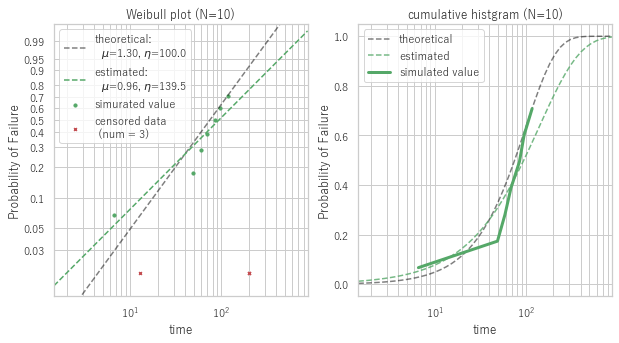

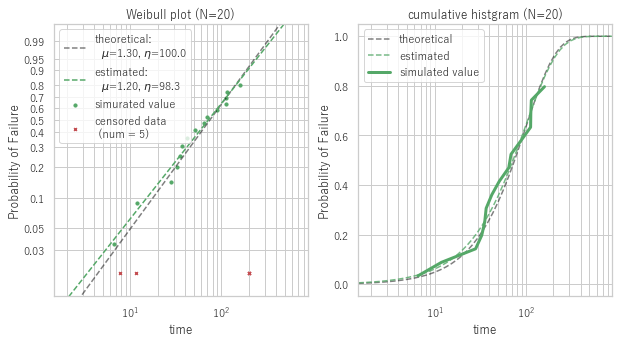

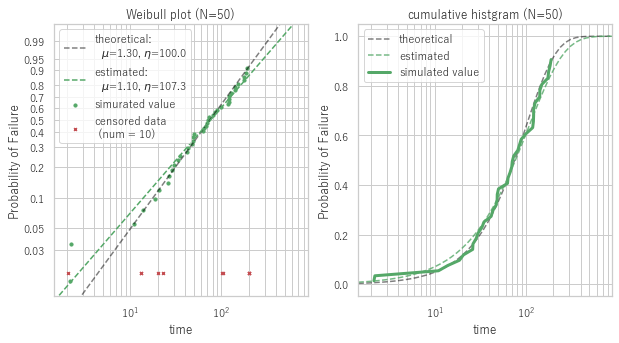

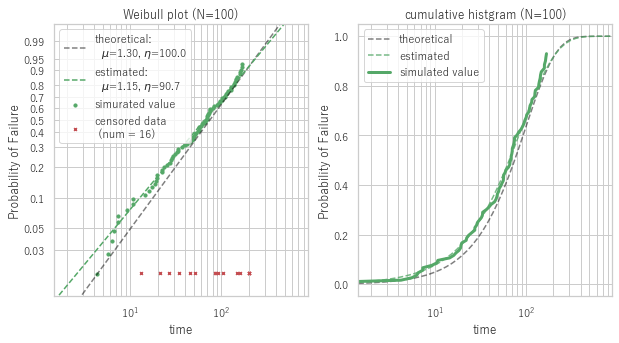

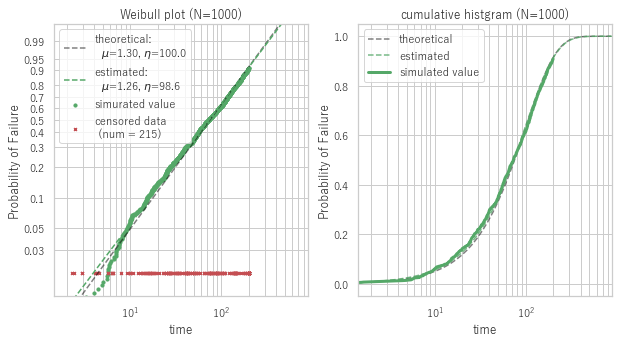

In [2]:
num_list=[10,20,50,100,1000]
for num in num_list:
    m = weibull_test.WeibullTest(num=num, weibull_mu=1.3, weibull_eta=100, exp_lambda=0.0018, censored_time=200)
    fig, axes = m.make_plot(plot_theoritical=True)
plt.show()

## ベイズ推定

以降では、N=20の場合について上と同じ条件のシミュレーション結果に対しベイズ推定を行い、90%確信区間および、L10の事後分布を算出する。

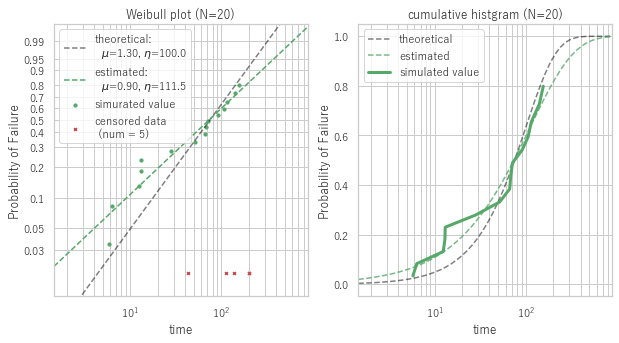

In [3]:
wb = weibull_bayes.Weibull_bayes(num = 20, weibull_mu=1.3, weibull_eta=100, exp_lambda=0.0018, censored_time=200)

fig, axes = wb.test.make_plot(plot_theoritical=True)


In [4]:
samples=wb.mcmc(loop_num=10000)

Sample: 100%|█████████████████████████████████████| 10500/10500 [03:00, 58.31it/s, step size=6.29e-01, acc. prob=0.868]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     mu[0]      0.95      0.22      0.94      0.61      1.30   3591.72      1.00
    eta[0]    120.22     40.78    112.71     64.40    175.54   1985.27      1.00

Number of divergences: 21


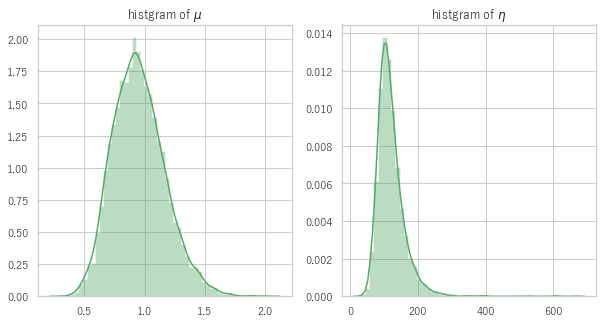

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.distplot(samples['mu'], ax = axes[0], color='g', hist_kws={'histtype':'stepfilled'})
sns.distplot(samples['eta'], ax = axes[1], color='g', hist_kws={'histtype':'stepfilled'})
axes[0].set_title(r'histgram of $\mu$')
axes[1].set_title(r'histgram of $\eta$')

plt.show()

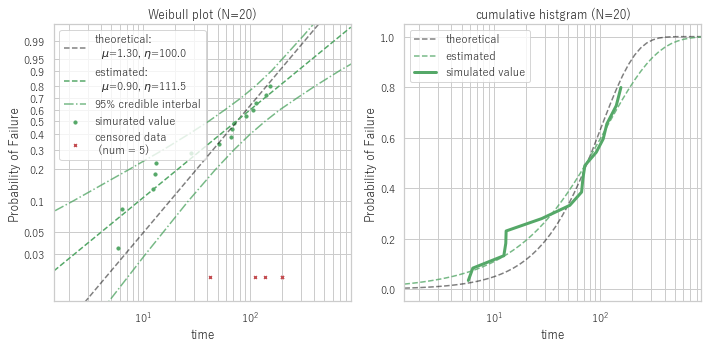

In [6]:
fig, axes = wb.test.make_plot(plot_theoritical=True)
freq=0.95
num = len(wb.failure_prob_samples[1][0])

y=wb.test.convert_unreliability_to_y(wb.failure_prob_samples[0])
sorted_fp_samples=np.sort(wb.failure_prob_samples[1], axis=1)

x_low=sorted_fp_samples[:,int(num*(1-freq)/2)]
x_high=sorted_fp_samples[:,int(num*(freq+(1-freq)/2))]

axes[0].plot(x_low,y, label='{0:.0f}% credible interbal'.format(freq*100), color='g', linestyle="-.",alpha=0.8)
axes[0].plot(x_high,y, color='g', linestyle="-.",alpha=0.8)
axes[0].legend(loc='upper left')
plt.tight_layout()
plt.show()
#plt.savefig(fname='test_weibull.png',format='png')

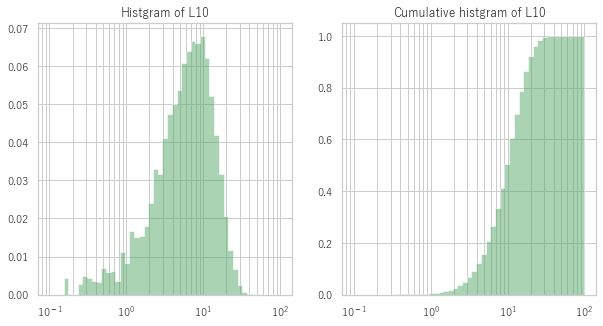

Average of L10: 11.4
90% credible interbal: 3.0, 23.3


In [7]:
freq=0.1
lifetime=wb.calc_freq_sample(freq)
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(10,5))
x_bins=np.logspace(np.floor(np.log10(lifetime.min())), np.ceil(np.log10(lifetime.max())))
axes[0].hist(lifetime, bins = x_bins, histtype='stepfilled',
        density = True, alpha=0.5, color='g')
axes[1].hist(lifetime, bins = x_bins, histtype='stepfilled',
        cumulative = True, density = True, alpha=0.5, color='g')


axes[0].set_xscale('log')
axes[0].set_title('Histgram of L{0:.0f}'.format(freq*100))
axes[1].set_xscale('log')
axes[1].set_title('Cumulative histgram of L{0:.0f}'.format(freq*100))
axes[0].grid(True,which='both',axis='x')
axes[1].grid(True,which='both',axis='x')

plt.show()

print('Average of L10: {0:.1f}'.format(np.average(lifetime)))
print('90% credible interbal: {0:.1f}, {1:.1f}'.format(*np.percentile(lifetime,[5,95])))

## まとめ
　以上のように、打ち切りデータが存在する場合についても、存在しない場合と同様にベイズ推定によりL10の平均値及び90%信頼区間を算出した。
 
## 今後の課題
　打ち切りデータを推定に用いることにより、推定精度がどの程度変わっているかを検討する。一定時間で打ち切った場合については、考慮に入れない場合に明らかに推定寿命が短くなってしまうが、予期せぬ中断については、考慮にいれなくとも推定の平均値に差は出ず、ばらつきのみに差が表れるはずである

## Appendix
　同様の手法でN=50の場合を以下に記載する。

Sample: 100%|█████████████████████████████████████| 10500/10500 [02:39, 65.74it/s, step size=7.29e-01, acc. prob=0.939]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     mu[0]      1.35      0.17      1.34      1.07      1.63   5029.94      1.00
    eta[0]    104.18     12.36    103.26     83.67    123.25   5663.52      1.00

Number of divergences: 0


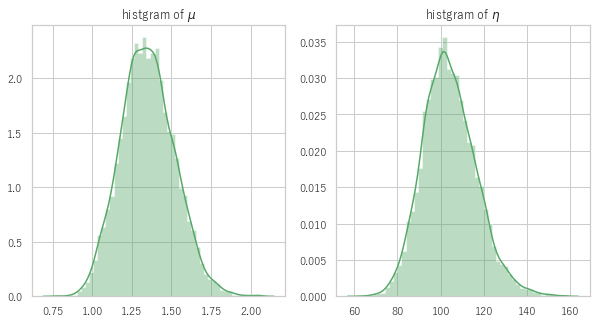

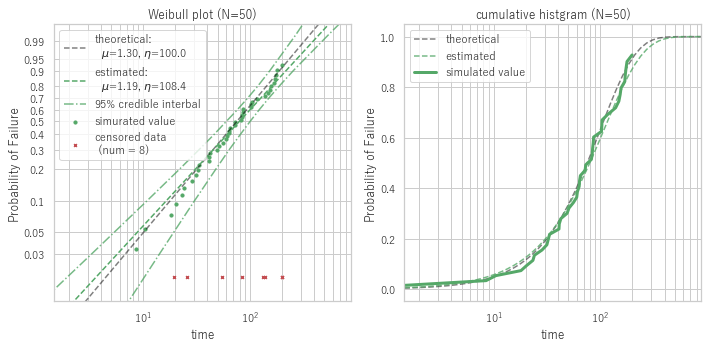

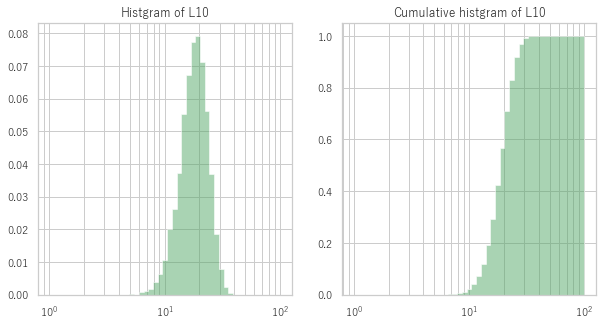

Average of L10: 19.7
90% credible interbal: 11.9, 28.3


In [8]:
wb = weibull_bayes.Weibull_bayes(num=50, weibull_mu=1.3, weibull_eta=100, exp_lambda=0.0018, censored_time=200)
samples=wb.mcmc(loop_num=10000)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.distplot(samples['mu'], ax = axes[0], color='g', hist_kws={'histtype':'stepfilled'})
sns.distplot(samples['eta'], ax = axes[1], color='g', hist_kws={'histtype':'stepfilled'})
axes[0].set_title(r'histgram of $\mu$')
axes[1].set_title(r'histgram of $\eta$')

plt.show()

fig, axes = wb.test.make_plot(plot_theoritical=True)
freq=0.95
num = len(wb.failure_prob_samples[1][0])

y=wb.test.convert_unreliability_to_y(wb.failure_prob_samples[0])
sorted_fp_samples=np.sort(wb.failure_prob_samples[1], axis=1)

x_low=sorted_fp_samples[:,int(num*(1-freq)/2)]
x_high=sorted_fp_samples[:,int(num*(freq+(1-freq)/2))]

axes[0].plot(x_low,y, label='{0:.0f}% credible interbal'.format(freq*100), color='g', linestyle="-.",alpha=0.8)
axes[0].plot(x_high,y, color='g', linestyle="-.",alpha=0.8)
axes[0].legend(loc='upper left')
plt.tight_layout()
plt.show()
#plt.savefig(fname='test_weibull.png',format='png')

freq=0.1
lifetime=wb.calc_freq_sample(freq)
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(10,5))
x_bins=np.logspace(np.floor(np.log10(lifetime.min())), np.ceil(np.log10(lifetime.max())))
axes[0].hist(lifetime, bins = x_bins, histtype='stepfilled',
        density = True, alpha=0.5, color='g')
axes[1].hist(lifetime, bins = x_bins, histtype='stepfilled',
        cumulative = True, density = True, alpha=0.5, color='g')


axes[0].set_xscale('log')
axes[0].set_title('Histgram of L{0:.0f}'.format(freq*100))
axes[1].set_xscale('log')
axes[1].set_title('Cumulative histgram of L{0:.0f}'.format(freq*100))
axes[0].grid(True,which='both',axis='x')
axes[1].grid(True,which='both',axis='x')

plt.show()

print('Average of L10: {0:.1f}'.format(np.average(lifetime)))
print('90% credible interbal: {0:.1f}, {1:.1f}'.format(*np.percentile(lifetime,[5,95])))